# Download US power output PV Watts (version 8) 

## Documentation: https://developer.nrel.gov/docs/api-key/
## https://pvwatts.nrel.gov/downloads/pvwattsv5.pdf

In [33]:
import numpy as np
import scipy as sp
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [34]:
hrh_apikey1 = 'GNoTfD5IZWwIEz24zB5Wn0aEhDvNJSep5bwapzTI'
hrh_apikey2 = 'bupvdoNsjaox9hQeCD6yufHWNf4cnM5OTNLlEBlZ'
hrh_apikey3 = 'wfaZg9uNJwCc9zJfiCXTEDnmloDEk0o6EATrdC6A'
hrh_apikey4 = '7iehBlUn3NW7rEEQYvMvB2xsinpbFQAnYGnrFoiy'
hrh_apikey5 =  'HGHXaFdKeMcknyEsmXnFMnL4aqgZK5HuZ5AV0tyG'
hrh_apikey6 = 'vPgwOy4OgMoOpnYtBsK5PyfEMwqD78HXCK5u1sNx'
data_path   = '/Users/hrh/Desktop/AI/erdos/rapower_data/'

In [3]:
# # 1. Define PVWatts parameters and your API key
# parameters = {
#     'format': 'json',
#     'system_capacity': 1000,
#     'module_type': 0,
#     'losses': 14.08,
#     'array_type': 1,
#     'tilt': 40,
#     'azimuth': 180,
#     'lat': 40.0099983215332,
#     'lon':  -105.2600021362305,
#     'dataset': 'nsrdb',
#     'radius': 25,
#     'timeframe': 'monthly',
#     'api_key': hrh_apikey1  # Replace with your API key
# }



In [4]:
# url = 'https://developer.nrel.gov/api/pvwatts/v8'

# # 2. Send request
# response = requests.get(url, params=parameters)
# data = response.json()

# # 3. Convert the output data to a DataFrame
# df = pd.DataFrame(data['outputs'])

# print(response)

<Response [200]>


In [5]:
##### Try to get data for California on a grid with lat_delta and lon_delta resolution
# lat_delta = 0.25
# lon_delta = 0.25

# # #CONUS box
# # top = 49.3457868 # north lat
# # left = -124.7844079 # west long
# # right = -66.9513812 # east long
# # bottom =  24.7433195 # south lat

# #California box
# top    = 42.009518
# bottom = 32.534156
# left   = -124.409591 
# right  =  -114.131211


### Threshold is a hyperparameter and will be applied to all variables

In [30]:
thresh_lb = 0.01 #lb = lower bound, applied to the feature ac_annual
thresh_ub = 0.99 #ub = upper bound, applied to the features elevation and slope (in this notebook)
thresh_name = '99'

## Define list of lat lon coordinates (either for CONUS or California)

<font color ='red'> PVWatts API access currently has a limit of 1000 queries per hour. So, data has to be downloaded one chunk (size<1000) at a time </font>

In [4]:
# 1. Define a list of latitudes and longitudes for CONUS
all_data = []
##### Read lats and lons CA_grid_dataframe #############
data_path2     = '/Users/hrh/Desktop/AI/erdos/SolarFarmPrediction/data/'
ca_gridpath    = data_path2 + 'threshold_90percentile/CA_data_version_11.csv'

df_main             = pd.read_csv(ca_gridpath)
ca_grid0            = df_main.loc[df_main['State']=='CA']
ca_grid0

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,land_cover,slope,elevation
0,40.417985,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,40.457093,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,40.398431,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,40.417985,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,40.437539,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91361,34.277993,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,201.0
91362,34.297547,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,31.0,228.0
91363,34.317101,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,20.0,148.0
91364,34.258439,-114.138592,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,112.0


In [5]:
### Remove rows where there is no data for land_cover,slope or elevation
ca_grid = ca_grid0.dropna(subset = ['slope','elevation','land_cover'])
ca_grid

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,land_cover,slope,elevation
0,40.417985,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,40.457093,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,40.398431,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,40.417985,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,40.437539,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91361,34.277993,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,201.0
91362,34.297547,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,31.0,228.0
91363,34.317101,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,20.0,148.0
91364,34.258439,-114.138592,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,112.0


In [6]:
#Check if it worked
ca_grid['slope'].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
91361    False
91362    False
91363    False
91364    False
91365    False
Name: slope, Length: 91330, dtype: bool

In [7]:
#ca_grid_usable      = ca_grid.loc[ca_grid['land_cover']==1.0]
ca_coords           = list(zip(ca_grid['Latitude'], ca_grid['Longitude']))
#Check if ca_coords are within california grid box
ca_lats = [item[0] for item in ca_coords] 
ca_lons = [item[1] for item in ca_coords]
(min(ca_lats),max(ca_lats)),(min(ca_lons),max(ca_lons))
ca_grid

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,land_cover,slope,elevation
0,40.417985,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,40.457093,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,40.398431,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,40.417985,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,40.437539,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91361,34.277993,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,201.0
91362,34.297547,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,31.0,228.0
91363,34.317101,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,20.0,148.0
91364,34.258439,-114.138592,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,112.0


### Reduce the grid points to those with solar farms and a a few sites with no solar farms

In [8]:
solar_farms = ca_grid.loc[ca_grid['Solar_farm_present']==1]
solar_farms

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,land_cover,slope,elevation
16282,40.633080,-122.314591,1.0,CA,0.026765,1.910786,702.0,0.026765,0.0,0.0,"JMJJ+R4 Columbia, Redding, CA, USA",1.0,1.0,185.0
16530,40.496202,-122.293018,1.0,CA,0.014312,1.127613,3.0,0.014312,0.0,0.0,"6759 Airport Rd, Redding, CA 96002, USA",1.0,0.0,149.0
16672,38.267033,-122.271446,1.0,CA,0.034076,NaN,3.0,0.034076,0.0,1.0,"7PCC+W7 Napa, CA, USA",1.0,1.0,9.0
18742,38.227924,-122.098865,1.0,CA,0.032722,2.263317,4.0,0.032722,0.0,0.0,"6WJ4+QW Fairfield, CA, USA",1.0,0.0,10.0
21251,37.719517,-121.904712,1.0,CA,0.028839,NaN,5.0,0.030839,0.0,1.0,"P3GR+8Q Dublin, CA, USA",1.0,2.0,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85756,35.588119,-115.432945,1.0,CA,5.889066,179.797992,6.0,5.889066,0.0,0.0,"HHP8+27 Calada, CA, USA",1.0,1.0,816.0
85969,33.828249,-115.389800,1.0,CA,14.031455,373.646009,6.0,14.031455,0.0,0.0,"RJ96+C8 Desert Center, CA, USA",1.0,0.0,216.0
89035,33.574045,-114.915204,1.0,CA,0.308603,NaN,3.0,0.308603,0.0,1.0,"H38J+CM Blythe, CA, USA",1.0,1.0,131.0
89164,33.574045,-114.893631,1.0,CA,0.033762,NaN,3.0,0.033762,0.0,1.0,"H38W+3C Blythe, CA, USA",1.0,0.0,133.0


### Let us pick locations where only one feature is restricting:

#### 1) Slope 2) Elevation 3) Land Cover

### The thresholds will be set at thresh_ub percentile of the feature set of existing solar farm locations

In [35]:
slope_threshold       = solar_farms['slope'].quantile(thresh_ub)
elevation_threshold   = solar_farms['elevation'].quantile(thresh_ub)
print(slope_threshold,elevation_threshold)  

20.93999999999997 976.96


In [10]:
np.sort(solar_farms['slope'])

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3

In [11]:
high_slope = ca_grid.loc[(ca_grid['Solar_farm_present']!=1) & (ca_grid['slope']>=slope_threshold) &(ca_grid['land_cover']!=0)]
high_slope

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,land_cover,slope,elevation
33,40.437539,-124.407129,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,22.0,76.0
58,40.437539,-124.385556,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,22.0,218.0
85,40.398431,-124.363984,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,21.0,270.0
145,40.241998,-124.320839,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,23.0,359.0
152,40.378877,-124.320839,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,30.0,466.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91352,34.317101,-114.203309,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,22.0,392.0
91353,34.336656,-114.203309,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,24.0,267.0
91357,34.277993,-114.181737,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,31.0,353.0
91359,34.317101,-114.181737,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,33.0,370.0


In [12]:
high_elevation = ca_grid.loc[(ca_grid['Solar_farm_present']!=1) & (ca_grid['elevation']>=elevation_threshold) & (ca_grid['slope']<slope_threshold) & (ca_grid['land_cover']!=0)]
high_elevation 

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,land_cover,slope,elevation
1999,41.923652,-123.889387,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1011.0
2359,40.828622,-123.824670,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,977.0
2494,40.554864,-123.803097,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9.0,1007.0
2520,41.063271,-123.803097,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,15.0,1143.0
2658,40.730851,-123.781525,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,17.0,995.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88595,35.255699,-115.001494,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,16.0,1045.0
88597,35.294807,-115.001494,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,6.0,994.0
89331,34.336656,-114.872059,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,12.0,992.0
89456,34.297547,-114.850486,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18.0,992.0


In [13]:
land_cover = ca_grid.loc[(ca_grid['Solar_farm_present']!=1) & (ca_grid['elevation'] < elevation_threshold) & (ca_grid['slope']<slope_threshold) & (ca_grid['land_cover']==0)]
land_cover

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,land_cover,slope,elevation
0,40.417985,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,40.457093,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,40.398431,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,40.417985,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,40.437539,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91241,34.551751,-114.397462,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,137.0
91290,34.434426,-114.332745,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,137.0
91354,34.356210,-114.203309,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,138.0
91360,34.336656,-114.181737,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,138.0


### Let us pick locations with low elevation, low slope and no land cover restrictions 

In [14]:
## I am calling these points rad_limited because they are not infeasible due to any other feature considered so far.
rad_limited = ca_grid.loc[(ca_grid['Solar_farm_present']!=1) & (ca_grid['elevation'] < elevation_threshold) & (ca_grid['slope']<slope_threshold) & (ca_grid['land_cover']!=0)]
rad_limited

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,land_cover,slope,elevation
57,40.417985,-124.385556,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,16.0,270.0
59,40.457093,-124.385556,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,8.0,193.0
60,40.476647,-124.385556,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,8.0,69.0
84,40.378877,-124.363984,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,13.0,28.0
87,40.437539,-124.363984,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,379.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91356,34.258439,-114.181737,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,7.0,160.0
91358,34.297547,-114.181737,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,258.0
91361,34.277993,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,201.0
91363,34.317101,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,20.0,148.0


In [16]:
## Number of locations to be sampled from rad_limited , 800 for each feature slope,elevation and land_cover ##############
radlim_size = 5000 - (len(solar_farms) + 2400)
radlim_size

2397

### Sample points from the dataframes to have a list of 5000 locations and set the labels

In [17]:
## Add extra column called fearture violated 
sample_high_elevation                       = high_elevation.sample(800,random_state=42)
sample_high_elevation['Solar_farm_present'] = 0
sample_high_elevation['feature_violated']   = 'elevation'
sample_high_elevation  

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,land_cover,slope,elevation,feature_violated
63354,34.199777,-117.892217,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,20.0,1040.0,elevation
50197,40.105119,-120.114190,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1277.0,elevation
31377,40.750405,-121.214390,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,1804.0,elevation
17353,41.513016,-122.228301,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1349.0,elevation
9752,41.082825,-122.940195,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1519.0,elevation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40014,41.258812,-120.675076,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1609.0,elevation
72550,35.157928,-116.964597,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1075.0,elevation
67939,36.116080,-117.417620,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,19.0,1325.0,elevation
84497,35.373024,-115.605526,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1299.0,elevation


In [18]:
sample_land_cover                       = land_cover.sample(800, random_state=42)
sample_land_cover['Solar_farm_present'] = 0
sample_land_cover['feature_violated']   = 'land_cover'
sample_land_cover      

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,land_cover,slope,elevation,feature_violated
37646,37.191556,-120.804512,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25.0,land_cover
2018,39.753145,-123.867815,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,land_cover
29032,39.577158,-121.365398,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,245.0,land_cover
935,40.378877,-124.083541,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,13.0,442.0,land_cover
1085,41.278366,-124.061968,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,20.0,23.0,land_cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53430,37.289327,-119.898464,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.0,366.0,land_cover
8131,37.739071,-123.091203,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,land_cover
19,41.825881,-124.428701,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,land_cover
13420,37.680409,-122.551889,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,land_cover


In [19]:
sample_high_slope                       = high_slope.sample(800, random_state=42)
sample_high_slope['Solar_farm_present'] = 0
sample_high_slope['feature_violated']   = 'slope'
sample_high_slope

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,land_cover,slope,elevation,feature_violated
79461,35.314361,-116.231130,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,24.0,577.0,slope
68807,36.624487,-117.331330,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,26.0,588.0,slope
28276,37.367543,-121.408543,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,28.0,771.0,slope
91021,34.551751,-114.526898,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,25.0,890.0,slope
42862,36.370283,-120.502496,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,26.0,586.0,slope
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71979,32.576785,-117.007742,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,21.0,128.0,slope
57358,34.629967,-118.496248,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,34.0,1170.0,slope
46759,35.001495,-120.286770,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,30.0,454.0,slope
78194,32.811435,-116.360565,0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,31.0,1629.0,slope


In [20]:
sample_rad_limited = rad_limited.sample(radlim_size,random_state=42)

### Combine data frames 

In [21]:
ca_grid_sampled = pd.concat([sample_rad_limited,sample_high_elevation,sample_high_slope,solar_farms,sample_land_cover])
ca_grid_sampled

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,land_cover,slope,elevation,feature_violated
80308,33.808694,-116.123267,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,868.0,NaN
81518,32.948313,-115.972259,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,12.0,161.0,NaN
87400,33.339396,-115.174074,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,425.0,NaN
20381,37.954167,-121.969430,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,82.0,NaN
86828,33.319842,-115.260365,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,484.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53430,37.289327,-119.898464,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.0,366.0,land_cover
8131,37.739071,-123.091203,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,land_cover
19,41.825881,-124.428701,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,land_cover
13420,37.680409,-122.551889,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,land_cover


In [22]:
###### Check #############
ca_grid_sampled.loc[ca_grid_sampled['feature_violated']=='slope']

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,land_cover,slope,elevation,feature_violated
79461,35.314361,-116.231130,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,24.0,577.0,slope
68807,36.624487,-117.331330,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,26.0,588.0,slope
28276,37.367543,-121.408543,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,28.0,771.0,slope
91021,34.551751,-114.526898,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,25.0,890.0,slope
42862,36.370283,-120.502496,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,26.0,586.0,slope
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71979,32.576785,-117.007742,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,21.0,128.0,slope
57358,34.629967,-118.496248,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,34.0,1170.0,slope
46759,35.001495,-120.286770,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,30.0,454.0,slope
78194,32.811435,-116.360565,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,31.0,1629.0,slope


In [23]:
#### Get lat and lons 
ca_coords_sample           = list(zip(ca_grid_sampled['Latitude'], ca_grid_sampled['Longitude']))
len(ca_coords_sample )
########
ca_coords_sample1 = ca_coords_sample[0:1000]
ca_coords_sample2 = ca_coords_sample[1000:2000]
ca_coords_sample3 = ca_coords_sample[2000:3000]
ca_coords_sample4 = ca_coords_sample[3000:4000]
ca_coords_sample5 = ca_coords_sample[4000:]
len(ca_coords_sample3)

1000

In [49]:
%%time
df = pd.DataFrame()
for (lat,lon) in ca_coords_sample5:
        
        parameters = {
            'format': 'json',
            'system_capacity': 1000, #1000kW = 1 MW, 1 MW or greater is considered utility-scale
            'module_type': 0,       # 0- Standard module, 1- Permium, 2-Thin film
            'losses': 14,           # Losses in percentage
            'array_type': 0,        # Open Rack: Also known as ground mount.
            'tilt': 40,
            'azimuth': 180,         # This means that the solar array is facing South in the Northeren Hemisphere
            'lat': lat,
            'lon': lon,
            'dataset': 'nsrdb',      #tmy2 is 1960-1990, tmy3 is 1990-2005
            'radius': 100,            # 0-Pick the station nearest to the given (lat,lon),e.g: 50 -50 miles
            'timeframe': 'monthly',
            'api_key': hrh_apikey4
        }

        url = 'https://developer.nrel.gov/api/pvwatts/v8'
        response = requests.get(url, params=parameters)
        data = response.json()
             
        # Extract and append relevant data to the all_data list
        # Extract relevant data
        #print('Processing (lat,lon):',lat,lon,'\n')
        
        # Check if 'outputs' is in the data
        if 'outputs' not in data:
            print(f"No data available for latitude {lat} and longitude {lon}")
            continue

        output_data = data['outputs']
        input_data  = data['inputs']

        output_data['latitude']  = input_data['lat']
        output_data['longitude'] = input_data['lon']
        all_data.append(output_data)
        
        
# Convert all_data to a DataFrame
df = pd.DataFrame(all_data)

print(df)

                                             ac_monthly  \
0     [149812.2726590896, 136770.8744561089, 168371....   
1     [146317.1261240209, 148262.3497309184, 175414....   
2     [144516.3593749663, 148097.8132090358, 175562....   
3     [96173.72130512354, 120312.542412835, 141419.0...   
4     [137510.2144402229, 142402.842983947, 176418.5...   
...                                                 ...   
4995  [95328.95100877596, 108990.8799538894, 140092....   
4996  [98227.38502469758, 98822.17157712391, 129850....   
4997  [70004.71455549274, 81380.2869646436, 111258.6...   
4998  [97087.35930445357, 100718.8764699389, 131161....   
4999  [78237.82390034462, 88023.91142518289, 106978....   

                                            poa_monthly  \
0     [186.7151101902774, 170.8804919632514, 217.140...   
1     [185.1047771788644, 188.8936772870372, 229.796...   
2     [181.8495609627761, 188.2728950639291, 227.919...   
3     [116.6067532589445, 150.3203686240996, 179.493...

In [50]:
df

,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,solrad_annual,capacity_factor,latitude,longitude
0,"[149812.2726590896, 136770.8744561089, 168371....","[186.7151101902774, 170.8804919632514, 217.140...","[6.023068070654109, 6.102874712973266, 7.00454...","[156676.9986566772, 143847.3499534745, 176220....",1.859524e+06,6.716675,21.227445,33.80869445875801,-116.1232669602395
1,"[146317.1261240209, 148262.3497309184, 175414....","[185.1047771788644, 188.8936772870372, 229.796...","[5.971121844479497, 6.746202760251329, 7.41278...","[152977.0310943529, 154960.2514255871, 183550....",1.853695e+06,6.776737,21.160906,32.94831342442612,-115.97225906105908
2,"[144516.3593749663, 148097.8132090358, 175562....","[181.8495609627761, 188.2728950639291, 227.919...","[5.86611486976697, 6.724031966568896, 7.352239...","[151186.7558117493, 155256.9241252177, 183816....",1.860760e+06,6.764995,21.241550,33.3393957127588,-115.17407445110544
3,"[96173.72130512354, 120312.542412835, 141419.0...","[116.6067532589445, 150.3203686240996, 179.493...","[3.761508169643369, 5.368584593717842, 5.79011...","[100873.0371669258, 125951.7057612103, 148151....",1.666310e+06,5.897817,19.021800,37.954166715084426,-121.9694299142244
4,"[137510.2144402229, 142402.842983947, 176418.5...","[170.9541471815402, 179.2420121822906, 228.486...","[5.514649909081941, 6.401500435081806, 7.37053...","[144075.5817489543, 149175.3389282349, 184759....",1.865764e+06,6.731896,21.298678,33.319841598342165,-115.26036467920852
...,...,...,...,...,...,...,...,...,...
4995,"[95328.95100877596, 108990.8799538894, 140092....","[118.9577276791649, 138.2276947748351, 180.570...","[3.837346054166609, 4.936703384815538, 5.82486...","[100087.7899723757, 114182.1553155137, 146825....",1.613157e+06,5.867103,18.415039,37.28932682491887,-119.89846443975006
4996,"[98227.38502469758, 98822.17157712391, 129850....","[118.3652248845635, 120.7404967134668, 160.861...","[3.81823306079237, 4.312160596909529, 5.189078...","[102995.0341308273, 103710.1192841655, 136314....",1.399526e+06,4.769962,15.976326,37.73907145650145,-123.09120287956468
4997,"[70004.71455549274, 81380.2869646436, 111258.6...","[85.00729048931791, 99.2293882865231, 137.4604...","[2.742170660945739, 3.543906724518682, 4.43420...","[73699.77919700817, 85539.98772560337, 116804....",1.309439e+06,4.515692,14.947938,41.82588136957796,-124.4287014151627
4998,"[97087.35930445357, 100718.8764699389, 131161....","[117.8435888861197, 123.3396122809835, 163.353...","[3.801406093100635, 4.404986152892268, 5.26946...","[101818.921886468, 105641.3434799164, 137531.3...",1.404255e+06,4.833776,16.030305,37.68040911325155,-122.55188895392033


In [51]:
# Save file in the appropriate threshold folder
threshold_path = data_path2 + 'threshold_'+thresh_name+'percentile/'
print(threshold_path)
df.to_csv(threshold_path +'nsrdb_monthly_chunk5.csv',index=False)

/Users/hrh/Desktop/AI/erdos/SolarFarmPrediction/data/threshold_99percentile/


In [52]:
df_check = pd.read_csv(threshold_path +'nsrdb_monthly_chunk5.csv')
df_check

,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,solrad_annual,capacity_factor,latitude,longitude
0,"[149812.2726590896, 136770.8744561089, 168371....","[186.7151101902774, 170.8804919632514, 217.140...","[6.023068070654109, 6.102874712973266, 7.00454...","[156676.9986566772, 143847.3499534745, 176220....",1.859524e+06,6.716675,21.227445,33.808694,-116.123267
1,"[146317.1261240209, 148262.3497309184, 175414....","[185.1047771788644, 188.8936772870372, 229.796...","[5.971121844479497, 6.746202760251329, 7.41278...","[152977.0310943529, 154960.2514255871, 183550....",1.853695e+06,6.776737,21.160906,32.948313,-115.972259
2,"[144516.3593749663, 148097.8132090358, 175562....","[181.8495609627761, 188.2728950639291, 227.919...","[5.86611486976697, 6.724031966568896, 7.352239...","[151186.7558117493, 155256.9241252177, 183816....",1.860760e+06,6.764995,21.241550,33.339396,-115.174074
3,"[96173.72130512354, 120312.542412835, 141419.0...","[116.6067532589445, 150.3203686240996, 179.493...","[3.761508169643369, 5.368584593717842, 5.79011...","[100873.0371669258, 125951.7057612103, 148151....",1.666310e+06,5.897817,19.021800,37.954167,-121.969430
4,"[137510.2144402229, 142402.842983947, 176418.5...","[170.9541471815402, 179.2420121822906, 228.486...","[5.514649909081941, 6.401500435081806, 7.37053...","[144075.5817489543, 149175.3389282349, 184759....",1.865764e+06,6.731896,21.298678,33.319842,-115.260365
...,...,...,...,...,...,...,...,...,...
4995,"[95328.95100877596, 108990.8799538894, 140092....","[118.9577276791649, 138.2276947748351, 180.570...","[3.837346054166609, 4.936703384815538, 5.82486...","[100087.7899723757, 114182.1553155137, 146825....",1.613157e+06,5.867103,18.415039,37.289327,-119.898464
4996,"[98227.38502469758, 98822.17157712391, 129850....","[118.3652248845635, 120.7404967134668, 160.861...","[3.81823306079237, 4.312160596909529, 5.189078...","[102995.0341308273, 103710.1192841655, 136314....",1.399526e+06,4.769962,15.976326,37.739071,-123.091203
4997,"[70004.71455549274, 81380.2869646436, 111258.6...","[85.00729048931791, 99.2293882865231, 137.4604...","[2.742170660945739, 3.543906724518682, 4.43420...","[73699.77919700817, 85539.98772560337, 116804....",1.309439e+06,4.515692,14.947938,41.825881,-124.428701
4998,"[97087.35930445357, 100718.8764699389, 131161....","[117.8435888861197, 123.3396122809835, 163.353...","[3.801406093100635, 4.404986152892268, 5.26946...","[101818.921886468, 105641.3434799164, 137531.3...",1.404255e+06,4.833776,16.030305,37.680409,-122.551889


In [53]:
# df0 = df.drop_duplicates(subset=['latitude','longitude'])
# df0

In [54]:
df_check.to_csv(threshold_path +'nsrdb_monthly.csv',index=False)

In [55]:
# ca_rad1 = pd.read_csv(data_path2+'nsrdb_monthly_chunk1.csv')
ca_rad = pd.read_csv(threshold_path +'nsrdb_monthly.csv')
ca_rad

,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,solrad_annual,capacity_factor,latitude,longitude
0,"[149812.2726590896, 136770.8744561089, 168371....","[186.7151101902774, 170.8804919632514, 217.140...","[6.023068070654109, 6.102874712973266, 7.00454...","[156676.9986566772, 143847.3499534745, 176220....",1.859524e+06,6.716675,21.227445,33.808694,-116.123267
1,"[146317.1261240209, 148262.3497309184, 175414....","[185.1047771788644, 188.8936772870372, 229.796...","[5.971121844479497, 6.746202760251329, 7.41278...","[152977.0310943529, 154960.2514255871, 183550....",1.853695e+06,6.776737,21.160906,32.948313,-115.972259
2,"[144516.3593749663, 148097.8132090358, 175562....","[181.8495609627761, 188.2728950639291, 227.919...","[5.86611486976697, 6.724031966568896, 7.352239...","[151186.7558117493, 155256.9241252177, 183816....",1.860760e+06,6.764995,21.241550,33.339396,-115.174074
3,"[96173.72130512354, 120312.542412835, 141419.0...","[116.6067532589445, 150.3203686240996, 179.493...","[3.761508169643369, 5.368584593717842, 5.79011...","[100873.0371669258, 125951.7057612103, 148151....",1.666310e+06,5.897817,19.021800,37.954167,-121.969430
4,"[137510.2144402229, 142402.842983947, 176418.5...","[170.9541471815402, 179.2420121822906, 228.486...","[5.514649909081941, 6.401500435081806, 7.37053...","[144075.5817489543, 149175.3389282349, 184759....",1.865764e+06,6.731896,21.298678,33.319842,-115.260365
...,...,...,...,...,...,...,...,...,...
4995,"[95328.95100877596, 108990.8799538894, 140092....","[118.9577276791649, 138.2276947748351, 180.570...","[3.837346054166609, 4.936703384815538, 5.82486...","[100087.7899723757, 114182.1553155137, 146825....",1.613157e+06,5.867103,18.415039,37.289327,-119.898464
4996,"[98227.38502469758, 98822.17157712391, 129850....","[118.3652248845635, 120.7404967134668, 160.861...","[3.81823306079237, 4.312160596909529, 5.189078...","[102995.0341308273, 103710.1192841655, 136314....",1.399526e+06,4.769962,15.976326,37.739071,-123.091203
4997,"[70004.71455549274, 81380.2869646436, 111258.6...","[85.00729048931791, 99.2293882865231, 137.4604...","[2.742170660945739, 3.543906724518682, 4.43420...","[73699.77919700817, 85539.98772560337, 116804....",1.309439e+06,4.515692,14.947938,41.825881,-124.428701
4998,"[97087.35930445357, 100718.8764699389, 131161....","[117.8435888861197, 123.3396122809835, 163.353...","[3.801406093100635, 4.404986152892268, 5.26946...","[101818.921886468, 105641.3434799164, 137531.3...",1.404255e+06,4.833776,16.030305,37.680409,-122.551889


In [56]:
# Convert DataFrame to GeoDataFrame
geometry       = [Point(xy) for xy in zip(ca_rad['longitude'], ca_rad['latitude'])]
geo_df_rad     = gpd.GeoDataFrame(ca_rad, geometry=geometry,crs = "EPSG:4326")

EPSG:4326


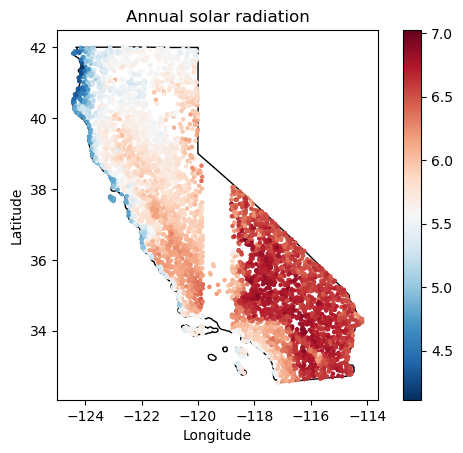

In [57]:
# Load the California shapefile
ca_shapfile_path = data_path+ 'ca_state_boundary/CA_State_TIGER2016.shp'
ca_shape         = gpd.read_file(ca_shapfile_path)
ca_shape         = ca_shape.to_crs("EPSG:4326")
print(ca_shape.crs)


# Plot the county boundaries
fig, ax = plt.subplots()
ca_shape.plot(ax=ax, color='white', edgecolor='black')

# Plot solar_rad data on top of the county boundaries
geo_df_rad.plot(ax=ax, column='solrad_annual', legend=True, markersize=5, cmap='RdBu_r',  missing_kwds={
        "color": "white",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    })


# geo_df_rad.plot(ax=ax, column='solrad_annual', legend=True, markersize=50, cmap='OrRd', alpha=0.5)

# Add titles and labels as needed
plt.title("Annual solar radiation")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the plot
plt.show()

EPSG:4326


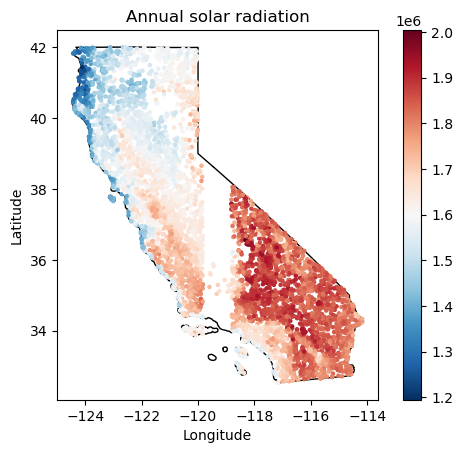

In [58]:
# Load the California shapefile
ca_shapfile_path = data_path+ 'ca_state_boundary/CA_State_TIGER2016.shp'
ca_shape         = gpd.read_file(ca_shapfile_path)
ca_shape         = ca_shape.to_crs("EPSG:4326")
print(ca_shape.crs)


# Plot the county boundaries
fig, ax = plt.subplots()
ca_shape.plot(ax=ax, color='white', edgecolor='black')

# Plot solar_rad data on top of the county boundaries
geo_df_rad.plot(ax=ax, column='ac_annual', legend=True, markersize=5, cmap='RdBu_r',  missing_kwds={
        "color": "white",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    })


# geo_df_rad.plot(ax=ax, column='solrad_annual', legend=True, markersize=50, cmap='OrRd', alpha=0.5)

# Add titles and labels as needed
plt.title("Annual solar radiation")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the plot
plt.show()

## Add data to big dataframe

#### Find threshold for ac_annual. Exclude the bottom thresh_lb * 100 %

In [59]:
ac_annual_threshold = geo_df_rad['ac_annual'].quantile(q=thresh_lb)
ac_annual_threshold 

1310571.467562323

In [60]:
# Ensure both GeoDataFrames have the same CRS
# Convert ca_features to a GeoDataFrame
gdf_ca_features = gpd.GeoDataFrame(
    ca_grid_sampled, 
    geometry=gpd.points_from_xy(ca_grid_sampled.Longitude, ca_grid_sampled.Latitude),
    crs="EPSG:4326"
)

# Ensure ca_rad is a GeoDataFrame with the same CRS
gdf_ca_rad = gpd.GeoDataFrame(
    ca_rad,
    geometry=gpd.points_from_xy(ca_rad.longitude, ca_rad.latitude),
    crs="EPSG:4326"
)

# Reproject to a suitable projected CRS for accurate distance calculations
gdf_ca_features = gdf_ca_features.to_crs("EPSG:3310")
gdf_ca_rad      = gdf_ca_rad.to_crs("EPSG:3310")


In [61]:
# Perform the spatial join to find the nearest neighbors and get their 'elevation'
ca_features_with_solar_data = gpd.sjoin_nearest(gdf_ca_features, gdf_ca_rad[['geometry', 'solrad_annual','ac_monthly', 'poa_monthly', 'solrad_monthly','dc_monthly','ac_annual']],\
                                                how='left', distance_col='distance')
ca_features_with_solar_data

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,...,feature_violated,geometry,index_right,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,distance
80308,33.808694,-116.123267,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,POINT (358918.607 -460045.457),0,6.716675,"[149812.2726590896, 136770.8744561089, 168371....","[186.7151101902774, 170.8804919632514, 217.140...","[6.023068070654109, 6.102874712973266, 7.00454...","[156676.9986566772, 143847.3499534745, 176220....",1.859524e+06,0.0
81518,32.948313,-115.972259,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,POINT (376941.408 -554740.827),1,6.776737,"[146317.1261240209, 148262.3497309184, 175414....","[185.1047771788644, 188.8936772870372, 229.796...","[5.971121844479497, 6.746202760251329, 7.41278...","[152977.0310943529, 154960.2514255871, 183550....",1.853695e+06,0.0
87400,33.339396,-115.174074,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,POINT (449376.215 -507974.768),2,6.764995,"[144516.3593749663, 148097.8132090358, 175562....","[181.8495609627761, 188.2728950639291, 227.919...","[5.86611486976697, 6.724031966568896, 7.352239...","[151186.7558117493, 155256.9241252177, 183816....",1.860760e+06,0.0
20381,37.954167,-121.969430,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,POINT (-172808.435 -5119.557),3,5.897817,"[96173.72130512354, 120312.542412835, 141419.0...","[116.6067532589445, 150.3203686240996, 179.493...","[3.761508169643369, 5.368584593717842, 5.79011...","[100873.0371669258, 125951.7057612103, 148151....",1.666310e+06,0.0
86828,33.319842,-115.260365,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,POINT (441456.169 -510544.642),4,6.731896,"[137510.2144402229, 142402.842983947, 176418.5...","[170.9541471815402, 179.2420121822906, 228.486...","[5.514649909081941, 6.401500435081806, 7.37053...","[144075.5817489543, 149175.3389282349, 184759....",1.865764e+06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53430,37.289327,-119.898464,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,land_cover,POINT (8989.155 -80816.957),4995,5.867103,"[95328.95100877596, 108990.8799538894, 140092....","[118.9577276791649, 138.2276947748351, 180.570...","[3.837346054166609, 4.936703384815538, 5.82486...","[100087.7899723757, 114182.1553155137, 146825....",1.613157e+06,0.0
8131,37.739071,-123.091203,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,land_cover,POINT (-271989.849 -26391.579),4996,4.769962,"[98227.38502469758, 98822.17157712391, 129850....","[118.3652248845635, 120.7404967134668, 160.861...","[3.81823306079237, 4.312160596909529, 5.189078...","[102995.0341308273, 103710.1192841655, 136314....",1.399526e+06,0.0
19,41.825881,-124.428701,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,land_cover,POINT (-368404.387 431730.014),4997,4.515692,"[70004.71455549274, 81380.2869646436, 111258.6...","[85.00729048931791, 99.2293882865231, 137.4604...","[2.742170660945739, 3.543906724518682, 4.43420...","[73699.77919700817, 85539.98772560337, 116804....",1.309439e+06,0.0
13420,37.680409,-122.551889,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,land_cover,POINT (-224724.571 -34322.789),4998,4.833776,"[97087.35930445357, 100718.8764699389, 131161....","[117.8435888861197, 123.3396122809835, 163.353...","[3.801406093100635, 4.404986152892268, 5.26946...","[101818.921886468, 105641.3434799164, 137531.3...",1.404255e+06,0.0


In [62]:


# If you don't need the distance information, drop the 'distance' column
ca_features_with_solar_data.drop(columns=['index_right', 'distance',], inplace=True)

# Optionally, project back to geographic CRS if needed for other purposes
ca_features_with_solar_data = ca_features_with_solar_data.to_crs("EPSG:4326")

ca_features_with_solar_data

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,...,slope,elevation,feature_violated,geometry,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual
80308,33.808694,-116.123267,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,868.0,NaN,POINT (-116.12327 33.80869),6.716675,"[149812.2726590896, 136770.8744561089, 168371....","[186.7151101902774, 170.8804919632514, 217.140...","[6.023068070654109, 6.102874712973266, 7.00454...","[156676.9986566772, 143847.3499534745, 176220....",1.859524e+06
81518,32.948313,-115.972259,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,161.0,NaN,POINT (-115.97226 32.94831),6.776737,"[146317.1261240209, 148262.3497309184, 175414....","[185.1047771788644, 188.8936772870372, 229.796...","[5.971121844479497, 6.746202760251329, 7.41278...","[152977.0310943529, 154960.2514255871, 183550....",1.853695e+06
87400,33.339396,-115.174074,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,425.0,NaN,POINT (-115.17407 33.33940),6.764995,"[144516.3593749663, 148097.8132090358, 175562....","[181.8495609627761, 188.2728950639291, 227.919...","[5.86611486976697, 6.724031966568896, 7.352239...","[151186.7558117493, 155256.9241252177, 183816....",1.860760e+06
20381,37.954167,-121.969430,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,82.0,NaN,POINT (-121.96943 37.95417),5.897817,"[96173.72130512354, 120312.542412835, 141419.0...","[116.6067532589445, 150.3203686240996, 179.493...","[3.761508169643369, 5.368584593717842, 5.79011...","[100873.0371669258, 125951.7057612103, 148151....",1.666310e+06
86828,33.319842,-115.260365,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,484.0,NaN,POINT (-115.26036 33.31984),6.731896,"[137510.2144402229, 142402.842983947, 176418.5...","[170.9541471815402, 179.2420121822906, 228.486...","[5.514649909081941, 6.401500435081806, 7.37053...","[144075.5817489543, 149175.3389282349, 184759....",1.865764e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53430,37.289327,-119.898464,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,366.0,land_cover,POINT (-119.89846 37.28933),5.867103,"[95328.95100877596, 108990.8799538894, 140092....","[118.9577276791649, 138.2276947748351, 180.570...","[3.837346054166609, 4.936703384815538, 5.82486...","[100087.7899723757, 114182.1553155137, 146825....",1.613157e+06
8131,37.739071,-123.091203,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,land_cover,POINT (-123.09120 37.73907),4.769962,"[98227.38502469758, 98822.17157712391, 129850....","[118.3652248845635, 120.7404967134668, 160.861...","[3.81823306079237, 4.312160596909529, 5.189078...","[102995.0341308273, 103710.1192841655, 136314....",1.399526e+06
19,41.825881,-124.428701,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,land_cover,POINT (-124.42870 41.82588),4.515692,"[70004.71455549274, 81380.2869646436, 111258.6...","[85.00729048931791, 99.2293882865231, 137.4604...","[2.742170660945739, 3.543906724518682, 4.43420...","[73699.77919700817, 85539.98772560337, 116804....",1.309439e+06
13420,37.680409,-122.551889,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,land_cover,POINT (-122.55189 37.68041),4.833776,"[97087.35930445357, 100718.8764699389, 131161....","[117.8435888861197, 123.3396122809835, 163.353...","[3.801406093100635, 4.404986152892268, 5.26946...","[101818.921886468, 105641.3434799164, 137531.3...",1.404255e+06


In [63]:
##Set value where ac_annual is below threshold
ac_annual_low   = (ca_features_with_solar_data['ac_annual']<=ac_annual_threshold) & (ca_features_with_solar_data['Solar_farm_present']!=1) \
& (ca_features_with_solar_data['elevation'] < elevation_threshold) \
& (ca_features_with_solar_data['slope']<slope_threshold) & (ca_features_with_solar_data['land_cover']!=0)

ca_features_with_solar_data.loc[ac_annual_low,'Solar_farm_present']=0
ca_features_with_solar_data.loc[ac_annual_low,'feature_violated']='ac_annual'
ca_features_with_solar_data

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,...,slope,elevation,feature_violated,geometry,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual
80308,33.808694,-116.123267,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,868.0,NaN,POINT (-116.12327 33.80869),6.716675,"[149812.2726590896, 136770.8744561089, 168371....","[186.7151101902774, 170.8804919632514, 217.140...","[6.023068070654109, 6.102874712973266, 7.00454...","[156676.9986566772, 143847.3499534745, 176220....",1.859524e+06
81518,32.948313,-115.972259,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,161.0,NaN,POINT (-115.97226 32.94831),6.776737,"[146317.1261240209, 148262.3497309184, 175414....","[185.1047771788644, 188.8936772870372, 229.796...","[5.971121844479497, 6.746202760251329, 7.41278...","[152977.0310943529, 154960.2514255871, 183550....",1.853695e+06
87400,33.339396,-115.174074,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,425.0,NaN,POINT (-115.17407 33.33940),6.764995,"[144516.3593749663, 148097.8132090358, 175562....","[181.8495609627761, 188.2728950639291, 227.919...","[5.86611486976697, 6.724031966568896, 7.352239...","[151186.7558117493, 155256.9241252177, 183816....",1.860760e+06
20381,37.954167,-121.969430,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,82.0,NaN,POINT (-121.96943 37.95417),5.897817,"[96173.72130512354, 120312.542412835, 141419.0...","[116.6067532589445, 150.3203686240996, 179.493...","[3.761508169643369, 5.368584593717842, 5.79011...","[100873.0371669258, 125951.7057612103, 148151....",1.666310e+06
86828,33.319842,-115.260365,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,484.0,NaN,POINT (-115.26036 33.31984),6.731896,"[137510.2144402229, 142402.842983947, 176418.5...","[170.9541471815402, 179.2420121822906, 228.486...","[5.514649909081941, 6.401500435081806, 7.37053...","[144075.5817489543, 149175.3389282349, 184759....",1.865764e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53430,37.289327,-119.898464,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,366.0,land_cover,POINT (-119.89846 37.28933),5.867103,"[95328.95100877596, 108990.8799538894, 140092....","[118.9577276791649, 138.2276947748351, 180.570...","[3.837346054166609, 4.936703384815538, 5.82486...","[100087.7899723757, 114182.1553155137, 146825....",1.613157e+06
8131,37.739071,-123.091203,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,land_cover,POINT (-123.09120 37.73907),4.769962,"[98227.38502469758, 98822.17157712391, 129850....","[118.3652248845635, 120.7404967134668, 160.861...","[3.81823306079237, 4.312160596909529, 5.189078...","[102995.0341308273, 103710.1192841655, 136314....",1.399526e+06
19,41.825881,-124.428701,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,land_cover,POINT (-124.42870 41.82588),4.515692,"[70004.71455549274, 81380.2869646436, 111258.6...","[85.00729048931791, 99.2293882865231, 137.4604...","[2.742170660945739, 3.543906724518682, 4.43420...","[73699.77919700817, 85539.98772560337, 116804....",1.309439e+06
13420,37.680409,-122.551889,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,land_cover,POINT (-122.55189 37.68041),4.833776,"[97087.35930445357, 100718.8764699389, 131161....","[117.8435888861197, 123.3396122809835, 163.353...","[3.801406093100635, 4.404986152892268, 5.26946...","[101818.921886468, 105641.3434799164, 137531.3...",1.404255e+06


In [64]:
ca_features_with_solar_data.loc[ca_features_with_solar_data['Solar_farm_present'].isna()]

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,...,slope,elevation,feature_violated,geometry,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual
80308,33.808694,-116.123267,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,868.0,NaN,POINT (-116.12327 33.80869),6.716675,"[149812.2726590896, 136770.8744561089, 168371....","[186.7151101902774, 170.8804919632514, 217.140...","[6.023068070654109, 6.102874712973266, 7.00454...","[156676.9986566772, 143847.3499534745, 176220....",1.859524e+06
81518,32.948313,-115.972259,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,161.0,NaN,POINT (-115.97226 32.94831),6.776737,"[146317.1261240209, 148262.3497309184, 175414....","[185.1047771788644, 188.8936772870372, 229.796...","[5.971121844479497, 6.746202760251329, 7.41278...","[152977.0310943529, 154960.2514255871, 183550....",1.853695e+06
87400,33.339396,-115.174074,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,425.0,NaN,POINT (-115.17407 33.33940),6.764995,"[144516.3593749663, 148097.8132090358, 175562....","[181.8495609627761, 188.2728950639291, 227.919...","[5.86611486976697, 6.724031966568896, 7.352239...","[151186.7558117493, 155256.9241252177, 183816....",1.860760e+06
20381,37.954167,-121.969430,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,82.0,NaN,POINT (-121.96943 37.95417),5.897817,"[96173.72130512354, 120312.542412835, 141419.0...","[116.6067532589445, 150.3203686240996, 179.493...","[3.761508169643369, 5.368584593717842, 5.79011...","[100873.0371669258, 125951.7057612103, 148151....",1.666310e+06
86828,33.319842,-115.260365,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,484.0,NaN,POINT (-115.26036 33.31984),6.731896,"[137510.2144402229, 142402.842983947, 176418.5...","[170.9541471815402, 179.2420121822906, 228.486...","[5.514649909081941, 6.401500435081806, 7.37053...","[144075.5817489543, 149175.3389282349, 184759....",1.865764e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10251,38.716777,-122.875477,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,147.0,NaN,POINT (-122.87548 38.71678),5.749267,"[99041.69157518788, 111540.3173681198, 128436....","[121.0880246701978, 139.0332531266538, 162.421...","[3.906065311941863, 4.96547332595192, 5.239388...","[103818.8406038415, 116894.5438616144, 134700....",1.611441e+06
31870,37.543530,-121.171245,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,22.0,NaN,POINT (-121.17125 37.54353),5.919660,"[90394.83891832261, 102999.3938976192, 144402....","[111.8748931106097, 130.3828627797774, 185.149...","[3.608867519697086, 4.656530813563479, 5.97256...","[94935.02095969774, 107999.245898658, 151240.4...",1.646290e+06
8056,40.574418,-123.112775,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,782.0,NaN,POINT (-123.11278 40.57442),5.362307,"[82406.84348508224, 78714.88698187048, 121121....","[103.52201191522, 101.6885524976037, 160.72652...","[3.339419739200646, 3.631734017771561, 5.18472...","[86568.8139407866, 82803.00418348829, 127041.8...",1.430996e+06
89409,33.378504,-114.850486,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,17.0,290.0,NaN,POINT (-114.85049 33.37850),6.582220,"[141295.108800407, 145592.5621108934, 165815.8...","[178.3534905394432, 185.210978532498, 215.7191...","[5.753338404498167, 6.614677804732072, 6.95868...","[147820.9837073581, 152426.5419766086, 173534....",1.805870e+06


### Finally, save this data as a CSV file

In [65]:
ca_features_with_solar_data.drop(columns='geometry').to_csv(threshold_path +'ca_data_version_1.csv', index=False)

In [66]:
ca_features_with_solar_data_check = pd.read_csv(threshold_path +'ca_data_version_1.csv')
ca_features_with_solar_data_check 

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,...,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual
0,33.808694,-116.123267,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,3.0,868.0,NaN,6.716675,"[149812.2726590896, 136770.8744561089, 168371....","[186.7151101902774, 170.8804919632514, 217.140...","[6.023068070654109, 6.102874712973266, 7.00454...","[156676.9986566772, 143847.3499534745, 176220....",1.859524e+06
1,32.948313,-115.972259,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,12.0,161.0,NaN,6.776737,"[146317.1261240209, 148262.3497309184, 175414....","[185.1047771788644, 188.8936772870372, 229.796...","[5.971121844479497, 6.746202760251329, 7.41278...","[152977.0310943529, 154960.2514255871, 183550....",1.853695e+06
2,33.339396,-115.174074,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,425.0,NaN,6.764995,"[144516.3593749663, 148097.8132090358, 175562....","[181.8495609627761, 188.2728950639291, 227.919...","[5.86611486976697, 6.724031966568896, 7.352239...","[151186.7558117493, 155256.9241252177, 183816....",1.860760e+06
3,37.954167,-121.969430,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,82.0,NaN,5.897817,"[96173.72130512354, 120312.542412835, 141419.0...","[116.6067532589445, 150.3203686240996, 179.493...","[3.761508169643369, 5.368584593717842, 5.79011...","[100873.0371669258, 125951.7057612103, 148151....",1.666310e+06
4,33.319842,-115.260365,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,5.0,484.0,NaN,6.731896,"[137510.2144402229, 142402.842983947, 176418.5...","[170.9541471815402, 179.2420121822906, 228.486...","[5.514649909081941, 6.401500435081806, 7.37053...","[144075.5817489543, 149175.3389282349, 184759....",1.865764e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,37.289327,-119.898464,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,6.0,366.0,land_cover,5.867103,"[95328.95100877596, 108990.8799538894, 140092....","[118.9577276791649, 138.2276947748351, 180.570...","[3.837346054166609, 4.936703384815538, 5.82486...","[100087.7899723757, 114182.1553155137, 146825....",1.613157e+06
4996,37.739071,-123.091203,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,land_cover,4.769962,"[98227.38502469758, 98822.17157712391, 129850....","[118.3652248845635, 120.7404967134668, 160.861...","[3.81823306079237, 4.312160596909529, 5.189078...","[102995.0341308273, 103710.1192841655, 136314....",1.399526e+06
4997,41.825881,-124.428701,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,land_cover,4.515692,"[70004.71455549274, 81380.2869646436, 111258.6...","[85.00729048931791, 99.2293882865231, 137.4604...","[2.742170660945739, 3.543906724518682, 4.43420...","[73699.77919700817, 85539.98772560337, 116804....",1.309439e+06
4998,37.680409,-122.551889,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,land_cover,4.833776,"[97087.35930445357, 100718.8764699389, 131161....","[117.8435888861197, 123.3396122809835, 163.353...","[3.801406093100635, 4.404986152892268, 5.26946...","[101818.921886468, 105641.3434799164, 137531.3...",1.404255e+06


In [70]:
ca_features_with_solar_data_check.loc[(ca_features_with_solar_data_check['feature_violated']=='ac_annual')]

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,...,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual
934,40.437539,-123.975678,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,39.0,ac_annual,4.784442,"[73632.9171857727, 75673.88318434854, 110249.3...","[93.28023105614693, 96.59548343959324, 143.841...","[3.009039711488611, 3.449838694271187, 4.64005...","[77451.71467035527, 79641.17316570015, 115736....",1.302083e+06


In [68]:
ca_features_with_solar_data_check['feature_violated']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
4995    land_cover
4996    land_cover
4997    land_cover
4998    land_cover
4999    land_cover
Name: feature_violated, Length: 5000, dtype: object